## Package Installation and Data Loading

In [ ]:
! pip3 install ripser

In [ ]:
! pip3 install gudhi

In [1]:
import pandas as pd
import numpy as np
import networkx as nwx
from ripser import ripser
import persim
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from scipy.sparse import load_npz
import gudhi as gd
from igraph import Graph
from IPython.display import SVG, display
import matplotlib.pyplot as plt

In [2]:
ppi_df = pd.read_table("../data/Human_PPI_Network.txt", header=None)
ppi_df.columns = ["ProteinA", "ProteinB", "SemSim"]
ppi_df.head()

,ProteinA,ProteinB,SemSim
0,FLNC,MAP2K4,0.672667
1,ACTN2,MYPN,0.738667
2,ACVR1,FNTA,0.370000
3,PML,GATA2,0.632667
4,STAT3,RPA2,0.576000


In [3]:
complexes_list = []
with open("../data/CORUM_Human_Complexes.txt") as complexes:
  for line in complexes:
    line = line.strip()
    temp_list = list(line.split("\t"))
    complexes_list.append(temp_list)


# Ripser Persistent Homology

## Complexes Proteins Data-subset

### Extracting Data Subset

In [4]:
## We should first explore the individual proteins first
## Get unique proteins from the Complexes file
## Check common proteins
complexes_dict = {}
complexes_single_proteins = []
for idx, cmplx in enumerate(complexes_list):
  for protein in cmplx:
    if protein not in complexes_single_proteins:
      complexes_single_proteins.append(protein)

  complexes_dict[idx] = cmplx

print('There are %d individual proteins in the complexes' % len(complexes_single_proteins))

There are 3634 individual proteins in the complexes


In [5]:
complexes_proteins_df = ppi_df[(ppi_df['ProteinA'].isin(complexes_single_proteins)) & (ppi_df['ProteinB'].isin(complexes_single_proteins))]

In [5]:
complexes_proteins_idx = {protein: idx for idx, protein in enumerate(complexes_single_proteins)}

In [7]:
c_proteins = len(complexes_single_proteins)

In [15]:
## we should have a dictionary of proteins and all the complexes they belong to as a sort of label for each node
protein_cmplx_aff = {protein : [] for protein in complexes_single_proteins}
 
for idx, cmplx in complexes_dict.items():
    for protein in cmplx:
        protein_cmplx_aff[protein].append(idx)

In [ ]:
for protein, cmplxs in protein_cmplx_aff.items():
    print(f'Protein {protein} belongs to complex(es): {cmplxs}')

### Graph Visualization

In [13]:
cmplx_prot_net = nwx.from_pandas_edgelist(
        complexes_proteins_df,
        source='ProteinA',
        target='ProteinB',
        edge_attr='SemSim'
    )

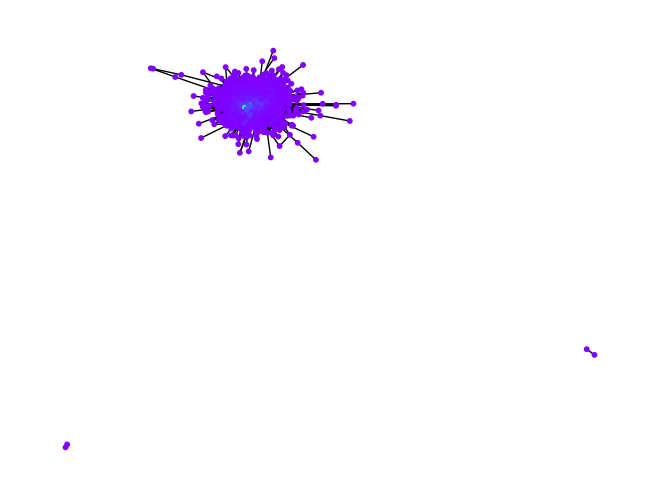

In [12]:
## The following graph shows us there are a couple of outliers (nodes connected exclusively to eachother)
scaled_degree = [d[1]*100 for d in nwx.degree(cmplx_prot_net)]
nwx.draw_spring(cmplx_prot_net,
        # Weights Based on Column
        #width=list(nwx.get_edge_attributes(cmplx_prot_net, 'SemSim').values()),
        # Node size based on degree
        node_size=10,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

In [10]:
## Let's check out the single-degree nodes and try to identify which protein-pairs form the outliers
one_degree_nodes = []
for degree in cmplx_prot_net.degree():
    if degree[1] == 1:
        one_degree_nodes.append(degree[0])

In [11]:
outlier_nodes = []
for edge in cmplx_prot_net.edges(data=True):
    if edge[0] in one_degree_nodes:
        if edge[1] in one_degree_nodes:
            print(edge)
            outlier_nodes.append(edge[0])

('GFRA3', 'ARTN', {'SemSim': 0.729})
('HAS2', 'HAS3', {'SemSim': 0.679})


In [19]:
## Drop data row with those specific nodes and re-define subset
ppi_df[(ppi_df['ProteinA'].isin(outlier_nodes))].head()
complexes_proteins_df = ppi_df[(ppi_df['ProteinA'].isin(complexes_single_proteins)) & (ppi_df['ProteinB'].isin(complexes_single_proteins))]

In [20]:
cmplx_prot_net = nwx.from_pandas_edgelist(
        complexes_proteins_df,
        source='ProteinA',
        target='ProteinB',
        edge_attr='SemSim'
    )

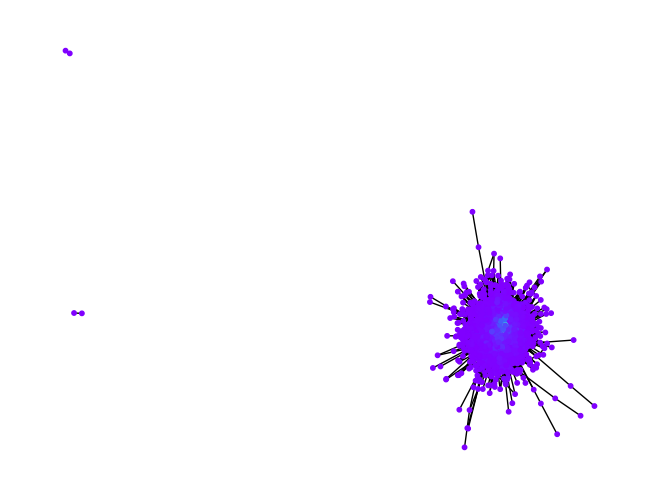

In [17]:
## The following graph shows us there are a couple of outliers (nodes connected exclusively to eachother)
scaled_degree = [d[1]*100 for d in nwx.degree(cmplx_prot_net)]
nwx.draw_spring(cmplx_prot_net,
        # Weights Based on Column
        #width=list(nwx.get_edge_attributes(cmplx_prot_net, 'SemSim').values()),
        # Node size based on degree
        node_size=10,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

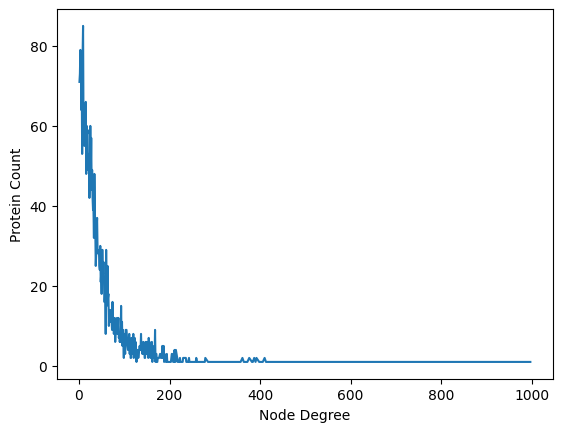

In [17]:
## Node Degree Viualization
## The following is just to check the distribution of the node degrees. As it seems like there are highly central nodes
degree_nodes = {}
for p, d in cmplx_prot_net.degree():
  degree_nodes[p] = d

## This gives that there are nodes with degree > 900
sorted_node_degrees = dict(sorted(degree_nodes.items(), key=lambda item: item[1],  reverse=True))

## Let's visualize the distribution
viz_degree = {degree: 0 for degree in degree_nodes.values()}
for degree in degree_nodes.values():
  viz_degree[degree]+=1
degree_count_pairs = sorted(viz_degree.items())
x, y = zip(*degree_count_pairs) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xlabel('Node Degree')
plt.ylabel('Protein Count')
plt.show()

### Creating Adjacency Matrix

In [18]:
complexes_adj_mat = np.matrix(np.zeros((c_proteins, c_proteins)))

In [19]:
for idx, row in complexes_proteins_df.iterrows():
  protein_A = complexes_proteins_idx[row['ProteinA']]
  protein_B = complexes_proteins_idx[row['ProteinB']]
  sem_sim_score = row['SemSim']
  complexes_adj_mat[protein_A, protein_B] = sem_sim_score
  complexes_adj_mat[protein_B, protein_A] = sem_sim_score

In [20]:
np.fill_diagonal(complexes_adj_mat, 1)
complexes_adj_mat

matrix([[1.        , 0.58133333, 0.61166667, ..., 0.        , 0.        ,
         0.        ],
        [0.58133333, 1.        , 0.86866667, ..., 0.        , 0.        ,
         0.        ],
        [0.61166667, 0.86866667, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ]])

### Vietoris Rips Persistence Filtration

In [21]:
## Define a function to plot barcode diagrams
def plot_barcode(diag, dim, **kwargs):
    #dim = 0
    diag_dim = diag[dim]
    birth = diag_dim[:, 0]; death = diag_dim[:, 1]
    finite_bars = death[death != np.inf]
    if len(finite_bars) > 0:
        inf_end = 2 * max(finite_bars)
    else:
        inf_end = 2
    death[death == np.inf] = inf_end
    plt.figure(figsize=kwargs.get('figsize', (10, 5)))
    for i, (b, d) in enumerate(zip(birth, death)):
        if d == inf_end:
            plt.plot([b, d], [i, i], color='k', lw=kwargs.get('linewidth', 2))
        else:
            plt.plot([b, d], [i, i], color=kwargs.get('color', 'b'), lw=kwargs.get('linewidth', 2))
    plt.title(kwargs.get('title', 'Persistence Barcode'))
    plt.xlabel(kwargs.get('xlabel', 'Filtration Value'))
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [22]:
cmplx_adj_mat = np.asarray(complexes_adj_mat)
cmplx_dist_mat = 1 - cmplx_adj_mat ## Using the adjacency matrix as a correlation matrix
cmplx_dist_mat

array([[0.        , 0.41866667, 0.38833333, ..., 1.        , 1.        ,
        1.        ],
       [0.41866667, 0.        , 0.13133333, ..., 1.        , 1.        ,
        1.        ],
       [0.38833333, 0.13133333, 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ]])

In [31]:
## TESTING
rips_dist_mat_diags = ripser(cmplx_dist_mat, distance_matrix=True)['dgms']

In [ ]:
plot_diagrams(rips_dist_mat_diags)

/opt/homebrew/lib/python3.11/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/opt/homebrew/lib/python3.11/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])


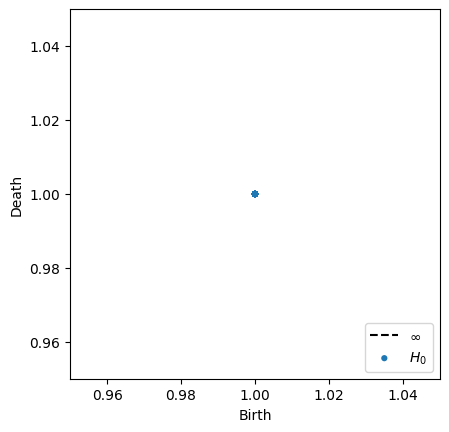

In [ ]:
plot_diagrams(rips_dist_mat_diags, plot_only=[0])

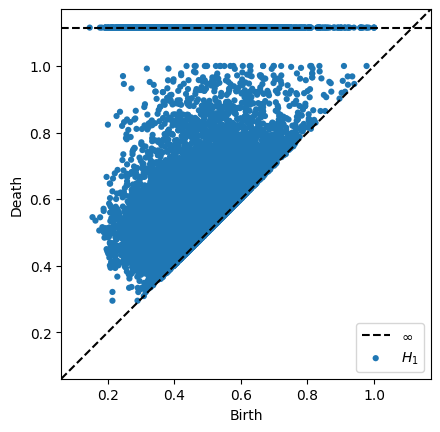

In [ ]:
plot_diagrams(rips_dist_mat_diags, plot_only=[1])

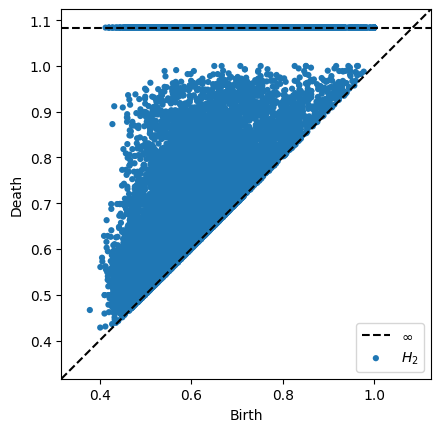

In [ ]:
plot_diagrams(rips_dist_mat_diags, plot_only=[2])

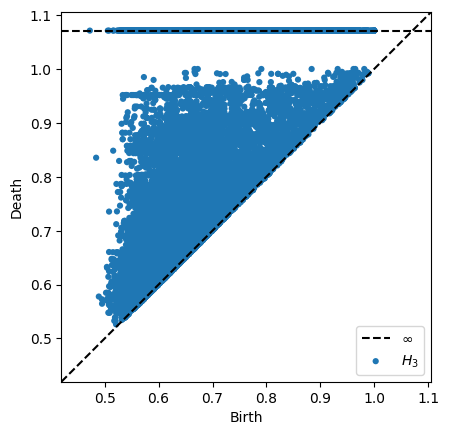

In [ ]:
plot_diagrams(rips_dist_mat_diags, plot_only=[3])

### PH on All complexes to generate Persistence Diagrams

In [56]:
import matplotlib

In [57]:
#matplotlib.use('Agg')
import matplotlib.pyplot as pltmatplotlib

In [6]:
tmp_cmplx = complexes_dict[171]
len(tmp_cmplx)

143

In [7]:
def extract_cmplx_df(cmplx):
    cmplx_source_df = ppi_df[ppi_df['ProteinA'].isin(cmplx)]
    cmplx_target_df = ppi_df[ppi_df['ProteinB'].isin(cmplx)]
    cmplx_df = pd.concat([cmplx_source_df, cmplx_target_df])
    cmplx_df.drop_duplicates()
    return cmplx_df

In [8]:
tmp_df = extract_cmplx_df(tmp_cmplx)

In [9]:
def create_subgraph(cmplx_df):
    tmp_G = nwx.from_pandas_edgelist(
        cmplx_df,
        source='ProteinA',
        target='ProteinB',
        edge_attr='SemSim'
    )
    return tmp_G

In [10]:
tmp_G = create_subgraph(tmp_df)

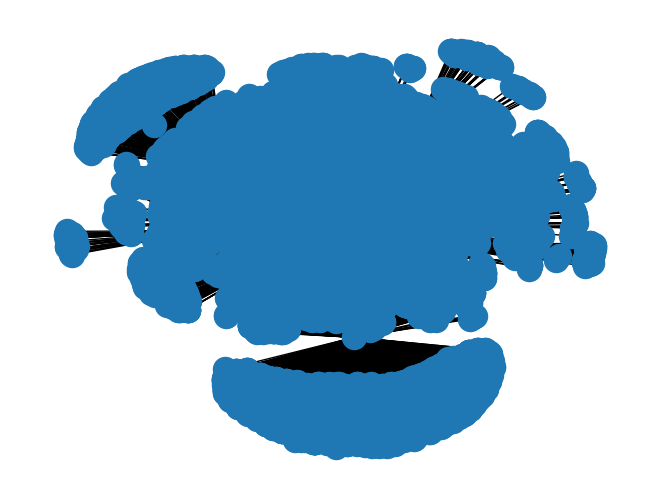

In [11]:
nwx.draw_spring(tmp_G)

In [13]:
for idx, row in tmp_df.iterrows():
    if row['SemSim'] == 0.0:
        tmp_df.drop(index=idx)

In [14]:
tmp_G = create_subgraph(tmp_df)

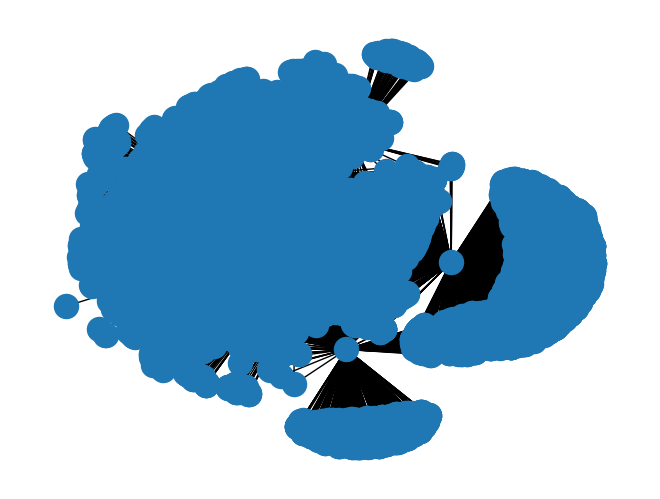

In [15]:
nwx.draw_spring(tmp_G)

In [17]:
def get_cmplx_dist_mat(cmplx_graph):
    cmplx_adj_mat = nwx.adjacency_matrix(cmplx_graph).toarray()
    np.fill_diagonal(cmplx_adj_mat, 1)
    cmplx_dist_mat = 1 - cmplx_adj_mat
    return cmplx_dist_mat

In [18]:
tmp_dist_mat = get_cmplx_dist_mat(tmp_G)

In [19]:
def generate_PD(cmplx_corr_dist_mat, cmplx_idx):
    cmplx_PD = ripser(cmplx_corr_dist_mat, distance_matrix = True)['dgms']
    diag_title = f'Persistence Diagram for Complex {cmplx_idx}'
    plot_diagrams(cmplx_PD, title=diag_title, legend= False)
    png_title = f'cmplx_pers_diags/{diag_title}.png'
    plt.savefig(png_title)
    cmplx_PD = None
    plt.close()

In [ ]:
generate_PD(tmp_dist_mat, 171)

In [ ]:
for idx, cmplx in complexes_dict.items():
     if len(cmplx) >= 3:
          cmplx_df = extract_cmplx_df(cmplx)
          tmp_cmplx_G = create_subgraph(cmplx_df)
          cmplx_dist_mat = get_cmplx_dist_mat(tmp_cmplx_G)
          generate_PD(cmplx_dist_mat, idx)
     

# Gudhi Persistent Homology

In [5]:
protein_net = nwx.from_pandas_edgelist(
    ppi_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)

## Build Simplex-Tree

In [ ]:
ppi_proteins = np.unique(ppi_df[['ProteinA', 'ProteinB']])

In [7]:
## Let's store the proteins in an indexed dictionary so we could track them back when building the simplex tree
proteins_dict = {protein: idx for idx, protein in enumerate(ppi_proteins)}

In [9]:
# Given protein-protein interaction network we can start by creating a simplex tree that includes all 0-simplices (nodes)

# Construct a simplex tree from the network
simplex_tree = gd.SimplexTree()

for edge in protein_net.edges(data=True):
    node1, node2, weight = edge
    ## Get protein index from dict to map it back and feed it into the simplex tree
    node1_idx = proteins_dict[node1]
    node2_idx = proteins_dict[node2]
    simplex_tree.insert([node1_idx, node2_idx], filtration=weight['SemSim'])


## Persistent Homology 

In [46]:
# Compute persistence diagrams
## NOTE: min_persistence is set to -1 to view all the simplex values (Include all 0-simplices)

persistence = simplex_tree.persistence(min_persistence=0, persistence_dim_max=True)

In [1]:
# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence)
barcode = gd.plot_persistence_barcode(persistence)
density = gd.plot_persistence_density(persistence)

NameError: name 'gd' is not defined

In [ ]:
for smplx in persistence:
    if smplx[0] == 0 and smplx[1][1] != np.inf:
        print(smplx)

In [52]:
st_filt_gen = simplex_tree.get_filtration()

In [ ]:
for smplx in st_filt_gen:
    print(smplx)

In [ ]:
simplex_tree.persistence_intervals_in_dimension(0)

## GUDHI RipsComplex Construction

In [ ]:
## Here we use the Gudhi library to build the Rips complex and apply the homology.
## We can build the Rips simplicial complex by using a distance matrix. So I just plugged in the correlation distance matrix.
rips_complex = gd.RipsComplex(distance_matrix=pn_distance_mat, max_edge_length=1.0)


## We now build a simplex tree to store the simplices
rips_simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)


## Check how the complex looks like
result_str = 'Rips complex is of dimension ' + repr(rips_simplex_tree.dimension()) + ' - ' + \
    repr(rips_simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(rips_simplex_tree.num_vertices()) + ' vertices.'

print(result_str)

Rips complex is of dimension 3 - 4087975 simplices - 100 vertices.


In [ ]:
persistence = rips_simplex_tree.persistence(min_persistence=-1, persistence_dim_max=True)

/opt/homebrew/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


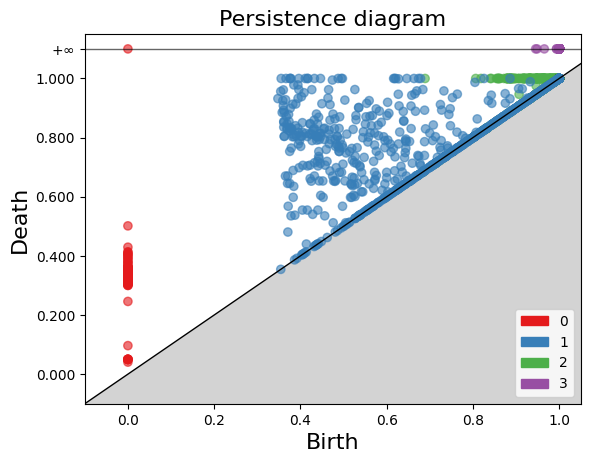

In [ ]:
# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence, max_intervals=4000000)


## Exploring Persistent Features

In [ ]:
def extract_pers_feat_in_dim(persistence_list, dim, birth_max, death_min):
    pers_feat = []
    for pt in persistence_list:
        pt_dim = pt[0]
        birth = pt[1][0]
        death = pt[1][1]
        if pt_dim == dim and birth < birth_max and death > death_min:
            pers_feat.append(list(pt[1]))
    return pers_feat

In [ ]:
dim_1_pers_features = extract_pers_feat_in_dim(persistence, 1, 0.62, 0.55)

In [ ]:
for filtered_value in rips_simplex_tree.get_filtration():
    dim = len(filtered_value[0])
    if dim == 2 and filtered_value[1] in dim_1_pers_features:
        print(filtered_value)

## DBSCAN Clustering

In [ ]:
## death values of np.inf would not give us a measure to cluster them with DBSCAN, so let's set a cap death time for those to a max value of 1
for pt in dim_1_pers_features:
    if pt[1] == np.inf:
        pt[1] = 1.0
        #print(pt)

In [ ]:

# Extract features from the persistence diagrams
# I will use just the birth and death times of the topological features for now and see how DBSCAN would perfrom in the clustering
features = np.array([[pt[0], pt[1]] for pt in dim_1_pers_features])


# Cluster the proteins into complexes using DBSCAN
dbscan = DBSCAN(eps=0.0065, min_samples=5)
dbscan.fit(features)

# Get the predicted labels (complexes)
predicted_labels = dbscan.labels_


In [ ]:
## TESTING 
len(predicted_labels)

279

In [ ]:
#def match_feat_to_filt():
pers_feat= []
for feat in dim_1_pers_features:
    pers_feat.append(feat[0])

In [ ]:
pers_simplices = []
for filt in rips_simplex_tree.get_filtration():
    if len(filt[0]) == 2 and filt[1] in pers_feat:
        pers_simplices.append(filt[0])
        

In [ ]:
for pers_pair in rips_simplex_tree.persistence_pairs():
    if pers_pair[0] in pers_simplices:
        print(pers_pair)

In [ ]:
# Print predicted complexes
complexes = {}
for i, protein in enumerate(proteins):
    label = predicted_labels[i]
    if label not in complexes:
        complexes[label] = []
    complexes[label].append(protein)

print("Predicted complexes:")
for label, members in complexes.items():
    print(f"Complex {label}: {', '.join(members)}")

Predicted complexes:
Complex -1: Protein_1, Protein_2, Protein_3, Protein_4, Protein_5, Protein_6, Protein_7, Protein_8, Protein_9, Protein_10, Protein_11, Protein_12, Protein_13, Protein_14, Protein_15, Protein_16, Protein_17, Protein_18, Protein_19, Protein_20, Protein_21, Protein_22, Protein_23, Protein_24, Protein_25, Protein_26, Protein_27, Protein_28, Protein_29, Protein_30, Protein_31, Protein_32, Protein_33, Protein_34, Protein_35, Protein_36, Protein_37, Protein_38, Protein_39, Protein_40, Protein_41, Protein_42, Protein_43, Protein_44, Protein_45, Protein_46, Protein_47, Protein_48, Protein_49, Protein_50, Protein_51, Protein_52, Protein_53, Protein_54, Protein_55, Protein_56, Protein_57, Protein_58, Protein_59, Protein_60, Protein_61, Protein_62, Protein_63, Protein_64, Protein_65, Protein_66, Protein_67, Protein_68, Protein_69, Protein_70, Protein_71, Protein_72, Protein_73, Protein_74, Protein_75, Protein_76, Protein_77, Protein_78, Protein_79, Protein_80, Protein_81, Prot

### DBSCAN Parameter Estimation

In [ ]:
# Calculate k-nearest neighbors epsilon-distances 
def calculate_kn_distance(X,k):
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i][0] - X[j][0]) ** 2) +
                    ((X[i][1] - X[j][1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

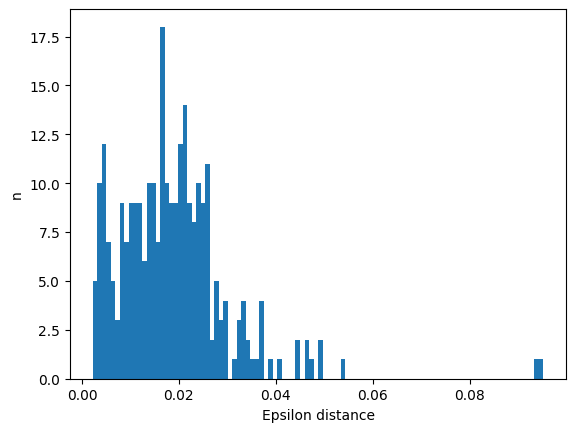

In [ ]:
## Plot eps_distances
eps_dist = calculate_kn_distance(dim_1_pers_features, 3)
plt.hist(eps_dist,bins=100)
plt.ylabel('n');
plt.xlabel('Epsilon distance');


## Persistence Landscapes

In [ ]:
rips_LS_dim1 = gd.representations.Landscape(num_landscapes=5).fit_transform([dist_mat_diags_ripser[1]])

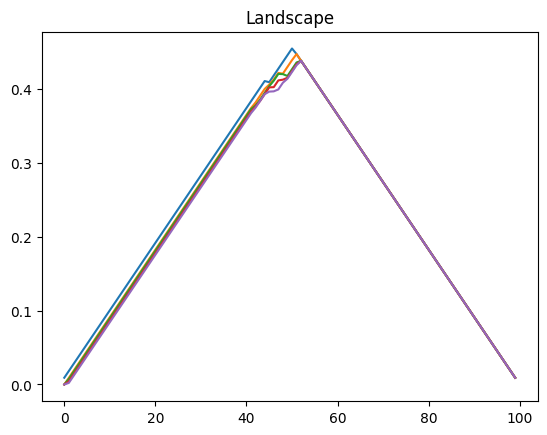

In [ ]:
plt.plot(rips_LS_dim1[0][:100])
plt.plot(rips_LS_dim1[0][100:200])
plt.plot(rips_LS_dim1[0][200:300])
plt.plot(rips_LS_dim1[0][300:400])
plt.plot(rips_LS_dim1[0][400:500])
plt.title("Landscape")
plt.show()

In [ ]:
rips_LS_dim2 = gd.representations.Landscape().fit_transform([dist_mat_diags_ripser[2]])

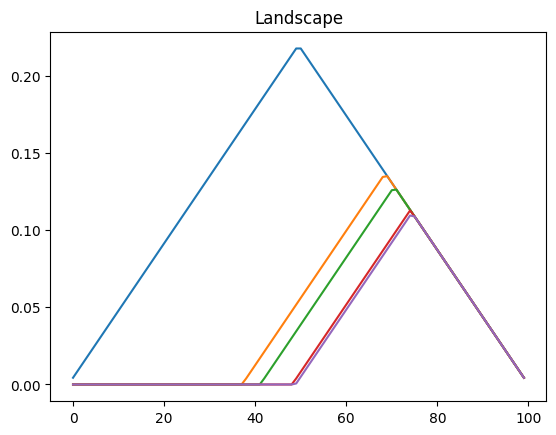

In [ ]:
plt.plot(rips_LS_dim2[0][:100])
plt.plot(rips_LS_dim2[0][100:200])
plt.plot(rips_LS_dim2[0][200:300])
plt.plot(rips_LS_dim2[0][300:400])
plt.plot(rips_LS_dim2[0][400:500])
plt.title("Landscape")
plt.show()

## Persistence Image

In [ ]:
pi = gd.representations.PersistenceImage(bandwidth=1e-2, weight=lambda x: x[1]**2, resolution=[500,500])

In [ ]:
rips_cmplx_pers_img  = pi.fit_transform([dist_mat_diags_ripser[1]])

In [ ]:
for pt in dist_mat_diags_ripser[1]:
    if pt[1] == np.inf:
        pt[1] = 1
    print(pt)

In [ ]:
len(rips_cmplx_pers_img[0])

250000

Text(0.5, 1.0, 'Persistence Image Dim 1')

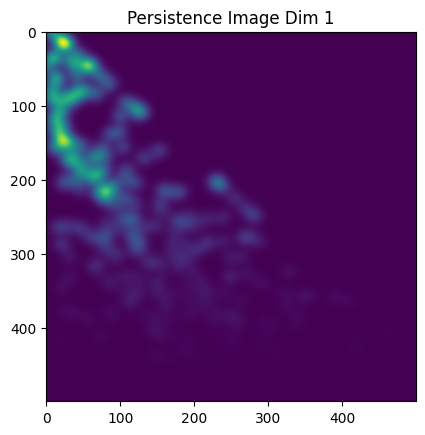

In [ ]:
plt.imshow(np.flip(np.reshape(rips_cmplx_pers_img[0], [500,500]), 0))
plt.title("Persistence Image Dim 1")